<a href="https://colab.research.google.com/github/JoaoVicLP/A2GerenciamentoLivraria/blob/main/2910p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar a biblioteca 'imbalanced-learn' para o SMOTE
!pip install imbalanced-learn

# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import warnings

# Ignorar avisos para manter a saída limpa
warnings.filterwarnings('ignore')

print("Bibliotecas importadas e prontas.")

Bibliotecas importadas e prontas.


In [ ]:
# --- Passo 0: Preparação e Análise Inicial ---
print("--- Iniciando Passo 0: Preparação e Análise dos Dados ---")

# 1. Carregar o CSV
try:
    df = pd.read_csv("/content/creditcard - menor balanceado.csv")
    print("Dataset 'creditcard - menor balanceado.csv' carregado com sucesso.")
except FileNotFoundError:
    print("Erro: Ficheiro 'creditcard - menor balanceado.csv' não encontrado.")
    print("Por favor, faça upload do ficheiro CSV para o ambiente do Google Colab.")

scaler = StandardScaler()
df['NormalizedAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

X = df.drop(['Time', 'Amount', 'Class'], axis=1)
y = df['Class']

print(f"\nFormato de X: {X.shape}")

class_distribution = y.value_counts()
print(f"\nDistribuição das Classes:\n{class_distribution}")
is_balanced = (class_distribution[0] / class_distribution[1]) < 1.5

# 4. Dividir em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Dados divididos: {len(X_train)} treino, {len(X_test)} teste.")
print("---------------------------------------------------\n")

--- Iniciando Passo 0: Preparação e Análise dos Dados ---
Dataset 'creditcard - menor balanceado.csv' carregado com sucesso.

Formato de X: (1759, 29)

Distribuição das Classes:
Class
0    1267
1     492
Name: count, dtype: int64
Dados divididos: 1231 treino, 528 teste.
---------------------------------------------------



In [ ]:
# --- Passo 1: Seleção de Atributos (Feature Selection) ---
print("--- Iniciando Passo 1: Seleção de Atributos ---")

k_best = SelectKBest(score_func=f_classif, k=20)
k_best.fit(X_train, y_train)

selected_features_mask = k_best.get_support()
selected_features_names = X_train.columns[selected_features_mask]

X_train_selected = X_train.loc[:, selected_features_names]
X_test_selected = X_test.loc[:, selected_features_names]

print(f"Features selecionadas (k=20): {list(selected_features_names)}")
print(f"Novo formato de X_train_selected: {X_train_selected.shape}")
print("---------------------------------------------------\n")

--- Iniciando Passo 1: Seleção de Atributos ---
Features selecionadas (k=20): ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V28']
Novo formato de X_train_selected: (1231, 20)
---------------------------------------------------



In [ ]:
# --- Passo 2: Técnicas de Balanceamento (Sampling) ---
print("--- Iniciando Passo 2: Técnicas de Balanceamento ---")

X_train_final = X_train_selected
y_train_final = y_train

if not is_balanced:
    print("Dataset identificado como desbalanceado. Aplicando SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_final, y_train_final = smote.fit_resample(X_train_selected, y_train)

    print("Balanceamento com SMOTE concluído.")
    print(f"Distribuição de treino original: {y_train.value_counts().to_dict()}")
    print(f"Nova distribuição de treino (SMOTE): {pd.Series(y_train_final).value_counts().to_dict()}")
else:
    print("O ficheiro CSV fornecido já está balanceado (ou próximo disso).")
    print("O passo de balanceamento (SMOTE) não foi executado.")

print("---------------------------------------------------\n")

--- Iniciando Passo 2: Técnicas de Balanceamento ---
Dataset identificado como desbalanceado. Aplicando SMOTE...
Balanceamento com SMOTE concluído.
Distribuição de treino original: {0: 887, 1: 344}
Nova distribuição de treino (SMOTE): {0: 887, 1: 887}
---------------------------------------------------



In [ ]:
# --- Passo 3: Tuning de Hiperparâmetros (Random Forest) ---
print("--- Iniciando Passo 3: Tuning de Hiperparâmetros (Random Forest) ---")

rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'criterion': ['gini', 'entropy']
}

grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='f1_macro',
                              n_jobs=-1,
                              verbose=1)

print("Iniciando GridSearchCV para Random Forest...")
grid_search_rf.fit(X_train_final, y_train_final)

print(f"\nMelhores parâmetros encontrados para RF: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_

print("---------------------------------------------------\n")

--- Iniciando Passo 3: Tuning de Hiperparâmetros (Random Forest) ---
Iniciando GridSearchCV para Random Forest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Melhores parâmetros encontrados para RF: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 200}
---------------------------------------------------



In [ ]:
# --- Passo 4: Ensemble de Modelos (Voting Classifier) ---
print("--- Iniciando Passo 4: Ensemble de Modelos (Voting Classifier) ---")

clf_dt = DecisionTreeClassifier(random_state=42)
clf_svm = SVC(probability=True, random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=5)

voting_clf = VotingClassifier(
    estimators=[
        ('dt', clf_dt),
        ('svm', clf_svm),
        ('knn', clf_knn)
    ],
    voting='hard'
)

print("Treinando o Voting Classifier (DT, SVM, KNN)...")
voting_clf.fit(X_train_final, y_train_final)
print("Voting Classifier treinado com sucesso.")
print("---------------------------------------------------\n")

--- Iniciando Passo 4: Ensemble de Modelos (Voting Classifier) ---
Treinando o Voting Classifier (DT, SVM, KNN)...
Voting Classifier treinado com sucesso.
---------------------------------------------------



In [ ]:
print("--- Iniciando Passo 5: Avaliação e Análise ---")

print("\n--- Avaliação do Modelo 1: Random Forest (Otimizado) ---")
y_pred_rf = best_rf_model.predict(X_test_selected)

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Macro F1-Score: {f1_score(y_test, y_pred_rf, average='macro'):.4f}")

print("\nMatriz de Confusão (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRelatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Classe 0 (Legítima)', 'Classe 1 (Fraude)']))


print("\n--- Avaliação do Modelo 2: Voting Classifier (DT, SVM, KNN) ---")
y_pred_voting = voting_clf.predict(X_test_selected)

print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print(f"Macro F1-Score: {f1_score(y_test, y_pred_voting, average='macro'):.4f}")

print("\nMatriz de Confusão (Voting Classifier):")
print(confusion_matrix(y_test, y_pred_voting))

print("\nRelatório de Classificação (Voting Classifier):")
print(classification_report(y_test, y_pred_voting, target_names=['Classe 0 (Legítima)', 'Classe 1 (Fraude)']))
print("---------------------------------------------------\n")

print("--- Análise Final ---")
print("Compare o 'Macro F1-Score', Precisão e Recall da 'Classe 1 (Fraude)' entre os dois modelos para concluir o seu trabalho.")

--- Iniciando Passo 5: Avaliação e Análise ---

--- Avaliação do Modelo 1: Random Forest (Otimizado) ---
Accuracy: 0.9545
Macro F1-Score: 0.9417

Matriz de Confusão (Random Forest):
[[376   4]
 [ 20 128]]

Relatório de Classificação (Random Forest):
                     precision    recall  f1-score   support

Classe 0 (Legítima)       0.95      0.99      0.97       380
  Classe 1 (Fraude)       0.97      0.86      0.91       148

           accuracy                           0.95       528
          macro avg       0.96      0.93      0.94       528
       weighted avg       0.96      0.95      0.95       528


--- Avaliação do Modelo 2: Voting Classifier (DT, SVM, KNN) ---
Accuracy: 0.9508
Macro F1-Score: 0.9377

Matriz de Confusão (Voting Classifier):
[[372   8]
 [ 18 130]]

Relatório de Classificação (Voting Classifier):
                     precision    recall  f1-score   support

Classe 0 (Legítima)       0.95      0.98      0.97       380
  Classe 1 (Fraude)       0.94      0.88

--- Iniciando Bloco 8: Visualização das Matrizes ---


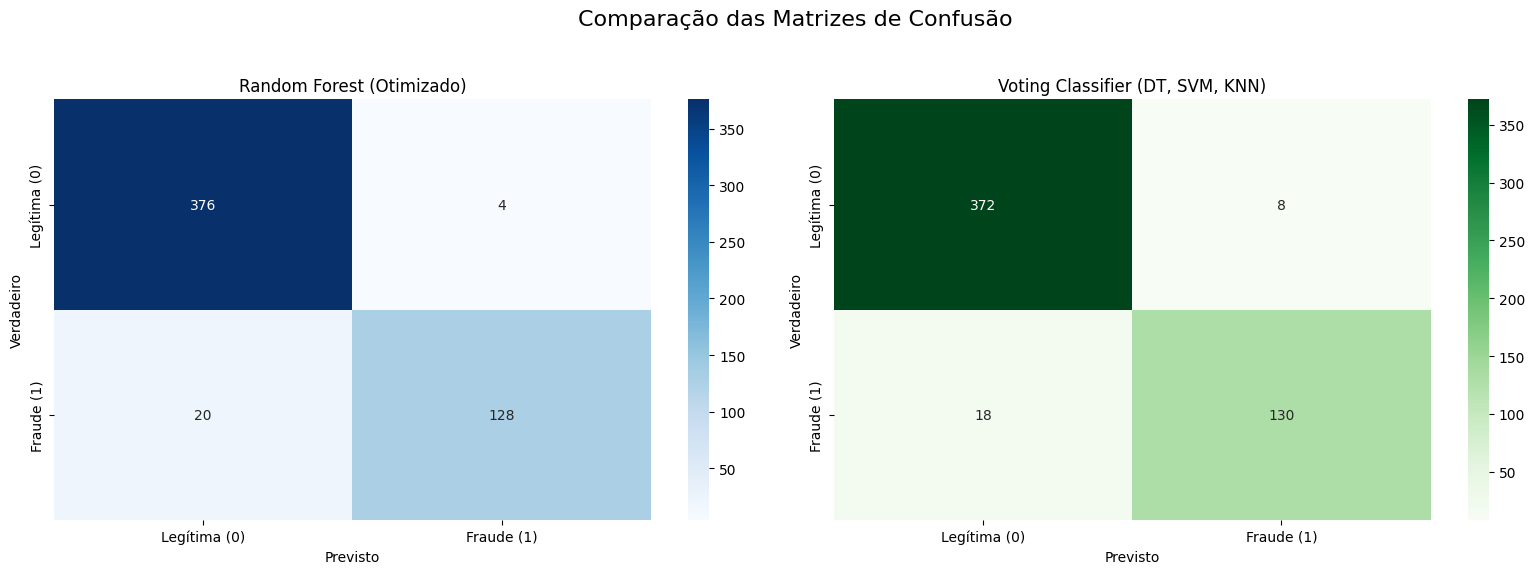

Gráficos gerados com sucesso.
---------------------------------------------------



In [ ]:
# --- Bloco 8: Visualização das Matrizes de Confusão ---
print("--- Iniciando Bloco 8: Visualização das Matrizes ---")

# Importar bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Obter as matrizes de confusão (já calculadas no Bloco 7, mas recriando para garantir)
# (Estas variáveis y_test, y_pred_rf, y_pred_voting vêm do Bloco 7)
try:
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    cm_voting = confusion_matrix(y_test, y_pred_voting)
except NameError:
    print("Erro: As variáveis 'y_test', 'y_pred_rf' ou 'y_pred_voting' não foram encontradas.")
    print("Certifique-se de que executou o Bloco 7 primeiro.")

target_names = ['Legítima (0)', 'Fraude (1)']

# 2. Criar os plots (lado a lado)
# Criamos uma figura com 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparação das Matrizes de Confusão', fontsize=16)

# Plot 1: Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names)
axes[0].set_title('Random Forest (Otimizado)')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Verdadeiro')

# Plot 2: Voting Classifier
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names)
axes[1].set_title('Voting Classifier (DT, SVM, KNN)')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Verdadeiro')

# 3. Exibir o plot no Colab
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para evitar sobreposição com o título
plt.show()

print("Gráficos gerados com sucesso.")
print("---------------------------------------------------\n")